# Regression and Other Stories: Beauty and sex ratio

Example where an informative prior makes a difference. See Chapter 9 in Regression and Other Stories.

----------

### Load packages

In [1]:
using Turing, MCMCChains, StatsPlots, DataFrames, GLM

## Data

In [2]:
x = -2:2
y = [50, 44, 50, 47, 56]
sexratio = DataFrame((x=x,y=y));

## Informative priors

In [3]:
theta_hat_prior = 0
se_prior = 0.25
theta_hat_data = 8
se_data = 3
theta_hat_bayes = (theta_hat_prior/se_prior^2 + theta_hat_data/se_data^2)/(1/se_prior^2 + 1/se_data^2)
se_bayes = sqrt(1/(1/se_prior^2 + 1/se_data^2));

## Least-squares regression

In [4]:
fit = lm(@formula(y ~ x), sexratio)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x

Coefficients:
─────────────────────────────────────────────────────────────────────
             Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────
(Intercept)   49.4     1.94422  25.41    0.0001   43.2126    55.5874
x              1.5     1.37477   1.09    0.3550   -2.87514    5.87514
─────────────────────────────────────────────────────────────────────

### Plot data and least-squares regression line

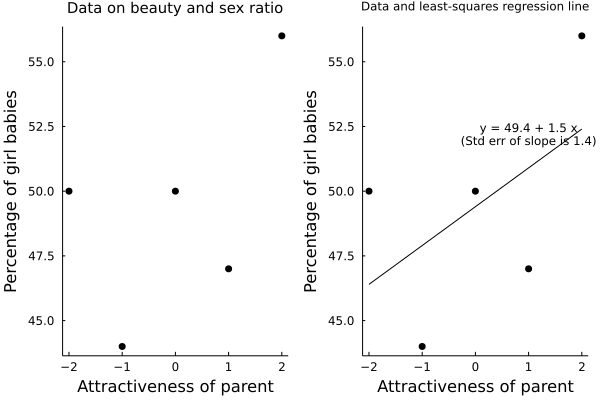

In [5]:
sty = Dict(
    :color=>:black,
    :grid=>false,
    :xlabel=>"Attractiveness of parent",
    :ylabel=>"Percentage of girl babies",
    :legend=>false,
)
p1 = scatter(x,y, title="Data on beauty and sex ratio", titlefontsize=10; sty...)
p2 = scatter(x,y,  title="Data and least-squares regression line", titlefontsize=8; sty...)
plot!( -2:2, x-> coef(fit)[1] + coef(fit)[2] * x, color=:black)
annotate!(1, 52.2, 
    text(string("y = ", round(coef(fit)[1], digits=1), " + ", round(coef(fit)[2], digits=1), " x\n(Std err of slope is ", round(stderror(fit)[2], digits=1), ")"), 8)
)
plot(p1,p2, layout=2)

## Bayesian regression with weakly informative prior

In [6]:
@model weak_linear(x,y) = begin

    # parameters
    α ~ Normal(49, 11)
    β ~ Normal(0, 7)
    # Note - original notebook has Exponential of rate 0.22
    # Distributions.jl appears to take the scale parameter, not rate. 
    # Scale of 4.5454 ~ Rate of 0.220
    σ ~ Exponential(4.545454) 
    # model
    μ = α .+ β * x
    y ~ MvNormal(μ, σ)
end;

In [7]:
model_default = weak_linear(sexratio.x, sexratio.y)
chains_default = sample(model_default, NUTS(), 5000)
summarystats(chains_default)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference C:\Users\tburch\.julia\packages\Turing\pwMQO\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03


Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           α   49.3659    2.2974     0.0325    0.0469   2956.8531    0.9999    ⋯
           β    1.4324    1.6102     0.0228    0.0241   3505.2583    0.9999    ⋯
           σ    5.0308    2.1333     0.0302    0.0524   1674.9111    0.9998    ⋯
                                                                1 column omitted


note - σ value is a little higher than original notebook

## Bayesian regression with informative prior

In [8]:
@model informative_linear(x,y) = begin

    # parameters
    α ~ Normal(48.8, 0.5)
    β ~ Normal(0, 0.2)
    σ ~ Exponential(4.545454)
    # model
    μ = α .+ β * x
    y ~ MvNormal(μ, σ)
end;

In [9]:
model_informative = informative_linear(sexratio.x, sexratio.y)
chains_informative = sample(model_informative, NUTS(), 5000)
summarystats(chains_informative)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\tburch\.julia\packages\Turing\pwMQO\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           α   48.8444    0.4766     0.0067    0.0051   6545.1968    1.0001    ⋯
           β    0.0380    0.1990     0.0028    0.0030   7277.6499    0.9998    ⋯
           σ    4.6577    1.7186     0.0243    0.0210   5137.3435    0.9999    ⋯
                                                                1 column omitted


### Plot Posterior simulations under weakly informative and informative prior

In [10]:
ppc_default = predict(model_default,chains_default, include_all=true)
ppc_informative = predict(model_informative,chains_informative, include_all=true);

In [11]:
α_default = get(ppc_default,[:α]).α.data
β_default = get(ppc_default,[:β]).β.data
mean_α_def = mean(α_default)
mean_β_def = mean(β_default)

α_inf = get(ppc_informative,[:α]).α.data
β_inf = get(ppc_informative,[:β]).β.data
mean_α_inf = mean(α_inf)
mean_β_inf = mean(β_inf);

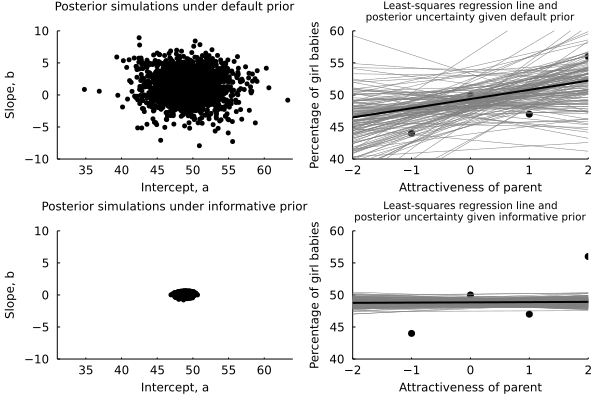

In [12]:
# First do coefficient plots
############################
sty2 = Dict(
    :grid=>false,
    :legend=>false,
    :color=>:black,
    :xlim=>(31,64),
    :ylim=>(-10,10),
    :markersize=>3,
    :xlabel=>"Intercept, a",
    :ylabel=>"Slope, b",
    :titlefontsize=>8,
    :guidefontsize=>8,
    
)
p1 = scatter( α_default, β_default,
    title="Posterior simulations under default prior";sty2...)
p3 = scatter(α_inf,β_inf,
    title="Posterior simulations under informative prior"; sty2...)

# Next do linear fits
#####################
sty3 = Dict(
    :color=>:black,
    :grid=>false,
    :xlabel=>"Attractiveness of parent",
    :ylabel=>"Percentage of girl babies",
    :legend=>false,
    :xlim=>(-2,2),
    :ylim=>(40,60),
    :titlefontsize=>7,
    :guidefontsize=>8,

)
# Plot data
p2 = scatter(x,y, 
    title="Least-squares regression line and\nposterior uncertainty given default prior", 
    ; sty3...)
# Plot random draws from chain
for i in 1:150
    plot!(
        -2:2,
        α_default[i] .+ β_default[i] * x,
        color=:gray50,linewidth=0.5
    )
end
# Plot mean value
plot!(-2:2, x->mean_α_def .+ mean_β_def * x, color=:black, linewidth=2)

# Repeat for informative priors
p4 = scatter(x,y, 
    title="Least-squares regression line and\nposterior uncertainty given informative prior", 
    titlefontsize=6,
    ;sty3...)
for i in 1:150
    # Add random draws
    plot!(
        -2:2,
        α_inf[i] .+ β_inf[i] * x,
        color=:gray50,
        linewidth=0.5
    )
end
plot!(-2:2, x->mean_α_inf .+ mean_β_inf * x, color=:black, linewidth=2)

# Make full plot
plot(p1,p2,p3,p4, layout=4)